In [1]:
import openai
import pandas as pd
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import re

In [2]:
df = pd.read_csv('f_merged.csv')

In [3]:
df = df.rename(columns = {'f_cat' : 'Flavor Category', 'c_id':'Country', 'year' : 'Year', 'month':'Month', 'region' : 'Region', 'cat' : 'Product Category' })

In [4]:
df = df[['Year', 'Month', 'Region', 'Country', 'Product Category', 'Flavor Category']]

In [5]:
df.head()

,Year,Month,Region,Country,Product Category,Flavor Category
0,2015,12,Latin America,BR,RTDs,Citrus Fruit
1,2019,12,Asia Pacific,JP,Bakery,Other Dairy
2,2020,9,Europe,FR,Meals & Meal Centers,Other Savoury
3,2019,9,Europe,GB,Baby Food,Berry Fruit
4,2019,4,Europe,DE,Desserts & Ice Cream,Sugar


## What flavours dominate a particular market?

In [6]:
def dominant_flavors(df, year=None, month=None, country=None, region=None):

    filtered_df = df.copy()

    # Apply filters if provided
    if year:
        filtered_df = filtered_df[filtered_df["Year"] == year]
    if month:
        filtered_df = filtered_df[filtered_df["Month"] == month]
    if country:
        filtered_df = filtered_df[filtered_df["Country"] == country]
    if region:
        filtered_df = filtered_df[filtered_df["Region"] == region]

    # Determine the dominant flavors
    flavor_counts = filtered_df["Flavor Category"].value_counts().head(5)

    return flavor_counts

In [7]:
dominant_flavors(df, year=2021, month=None, country=None, region = 'Europe')

Flavor Category
Fruit        4978
Vegetable    4974
Spice        4581
Nut          3971
Chocolate    3041
Name: count, dtype: int64

In [8]:
def print_dominant_flavors(df, year=None, month=None, country=None, region=None):

    # Get the dominant flavors based on the filters
    top_flavors = dominant_flavors(df, year=year, month=month, country=country, region=region).head(3)

    if top_flavors.empty:
        print("No data available for the specified filters.")
        return

    # Construct the filter details dynamically
    filter_details = []
    if year: filter_details.append(f"Year: {year}")
    if month: filter_details.append(f"Month: {month}")
    if country: filter_details.append(f"Country: {country}")
    if region: filter_details.append(f"Region: {region}")

    filter_text = " | ".join(filter_details) if filter_details else "All Data"

    # Construct the output message
    flavor_list = ", ".join([f"'{flavor}' ({count} occurrences)" for flavor, count in top_flavors.items()])

    print(f"The top three popular flavors are {flavor_list} ({filter_text}).")

# Example Usage:
print_dominant_flavors(df, year=2021, month=None, country=None, region = 'Europe')


The top three popular flavors are 'Fruit' (4978 occurrences), 'Vegetable' (4974 occurrences), 'Spice' (4581 occurrences) (Year: 2021 | Region: Europe).


## What flavours are showing the fastest growth, independently of how popular they are?

In [9]:
def fastest_growing_flavors(df, year=None):
    """
    Determines the fastest-growing flavors over time based on the change in occurrences per year.
    If a year is specified, it returns the fastest-growing flavors in that specific year.
    Otherwise, it considers the entire dataset.
    """
    # Count occurrences of each flavor per year
    flavor_trends = df.groupby(["Year", "Flavor Category"]).size().unstack(fill_value=0)

    # Compute year-over-year growth
    growth_rates = flavor_trends.pct_change().fillna(0)

    # If a specific year is given, filter for that year only
    if year:
        if year in growth_rates.index:
            fastest_growth = growth_rates.loc[year].sort_values(ascending=False).head(5)
        else:
            return f"No data available for the year {year}."
    else:
        # Find the fastest-growing flavors over the entire period
        fastest_growth = growth_rates.mean().sort_values(ascending=False).head(5)

    return fastest_growth


In [10]:
fastest_growing_flavors(df)

Flavor Category
Other Flora      0.077529
Plant            0.051586
Bakery           0.048710
Tree             0.047910
Other Savoury    0.046300
dtype: float64

In [11]:
fastest_growing_flavors(df, year=2020)

Flavor Category
Rice           0.134146
Tree           0.108491
Other Flora    0.080576
Alcohol        0.077855
Plant          0.073248
Name: 2020, dtype: float64

In [12]:
def print_fastest_growing_flavors(df, year=None):
    """
    Prints the top five fastest-growing flavors over time based on the percentage change in occurrences.
    - If a year is specified, it returns the fastest-growing flavors in that specific year.
    - Otherwise, it considers the entire dataset.
    """
    # Get the fastest-growing flavors
    fastest_growth = fastest_growing_flavors(df, year=year)

    if isinstance(fastest_growth, str):  # Handles case where no data is available
        print(fastest_growth)
        return

    # Construct the filter details dynamically
    filter_text = f"Year: {year}" if year else "All Years"

    # Construct the output message
    flavor_list = ", ".join([f"'{flavor}' ({growth:.4f} growth rate)" for flavor, growth in fastest_growth.items()])

    print(f"The top five fastest-growing flavors are {flavor_list} ({filter_text}).")

# Example Usage:
print_fastest_growing_flavors(df)
print_fastest_growing_flavors(df, year=2020)


The top five fastest-growing flavors are 'Other Flora' (0.0775 growth rate), 'Plant' (0.0516 growth rate), 'Bakery' (0.0487 growth rate), 'Tree' (0.0479 growth rate), 'Other Savoury' (0.0463 growth rate) (All Years).
The top five fastest-growing flavors are 'Rice' (0.1341 growth rate), 'Tree' (0.1085 growth rate), 'Other Flora' (0.0806 growth rate), 'Alcohol' (0.0779 growth rate), 'Plant' (0.0732 growth rate) (Year: 2020).


## Based on historical data, what market is this flavour likely to move next?

In [13]:
def predict_flavor_expansion(df, flavor, region=None, country=None):
    """
    Predicts whether a given flavor is expanding or declining based on historical movement patterns.
    - If a region or country is specified, it considers only that area.
    - If no region or country is provided, it analyzes all areas.
    """
    # Ensure correct case for parameter names
    market_col = None
    if country:
        market_col = "Country"
        filtered_df = df[df["Country"] == country]
    elif region:
        market_col = "Region"
        filtered_df = df[df["Region"] == region]
    else:
        market_col = "Region"  # Default to region-level analysis
        filtered_df = df.copy()

    # Track flavor occurrences by market (Region/Country) and year
    flavor_movement = filtered_df[filtered_df["Flavor Category"] == flavor].groupby(["Year", market_col]).size().unstack(fill_value=0)

    # Ensure sufficient data for predictions
    if flavor_movement.empty or len(flavor_movement.index) < 2:
        return f"No historical data available for '{flavor}' in the specified area."

    # Compute year-over-year market growth
    recent_growth = flavor_movement.diff().iloc[-1].sum()  # Sum of all market growth changes

    # Determine expansion trend
    if recent_growth > 0:
        return f"The flavor '{flavor}' is expanding in {country if country else region if region else 'all markets'}."
    else:
        return f"The flavor '{flavor}' is stable or declining in {country if country else region if region else 'all markets'}."


In [14]:
predict_flavor_expansion(df, flavor="Berry Fruit", country="JP")  # Prediction for Japan

"The flavor 'Berry Fruit' is stable or declining in JP."

In [15]:
predict_flavor_expansion(df, flavor="Berry Fruit", region="Asia Pacific")  # Prediction for Europe

"The flavor 'Berry Fruit' is expanding in Asia Pacific."

In [16]:
predict_flavor_expansion(df, flavor="Berry Fruit")  # Prediction for all areas

"The flavor 'Berry Fruit' is stable or declining in all markets."

## Based on performance, how can we categorize flavours in a market? (Ex. new, trending etc.)

In [17]:
def categorize_flavors(df, flavor=None):
    """
    Categorizes flavors into groups based on performance trends: new, increasing, declining, or stable.
    If a specific flavor is provided, it returns only the category for that flavor; otherwise, it returns all.
    """
    # First appearance of each flavor
    first_appearance = df.groupby("Flavor Category")["Year"].min()

    # Count occurrences of each flavor per year
    flavor_trends = df.groupby(["Year", "Flavor Category"]).size().unstack(fill_value=0)

    # Compute growth rate
    growth_rates = flavor_trends.pct_change().fillna(0)

    # Identify categories
    categories = {}
    most_recent_year = df["Year"].max()

    for flav in flavor_trends.columns:
        first_year = first_appearance.get(flav, None)
        avg_growth = growth_rates[flav].mean()

        # Classification logic
        if first_year == most_recent_year:
            category = "New"
        elif avg_growth > 0.01:
            category = "Increasing"
        elif avg_growth < -0.01:
            category = "Declining"
        else:
            category = "Stable"

        categories[flav] = category

    # Convert to DataFrame
    flavor_categories = pd.DataFrame.from_dict(categories, orient="index", columns=["Category"])

    # Return specific flavor category if a flavor is given
    if flavor:
        if flavor in flavor_categories.index:
            return flavor_categories.loc[[flavor]]
        else:
            return f"No data available for the flavor '{flavor}'."

    return flavor_categories

In [18]:
categorize_flavors(df)

,Category
Alcohol,Increasing
Bakery,Increasing
Berry Fruit,Declining
Cereal,Increasing
Cheese,Stable
Chocolate,Stable
Citrus Fruit,Stable
Coffee,Stable
Confectionery,Increasing
Dessert,Increasing


In [19]:
categorize_flavors(df, flavor="Berry Fruit")

,Category
Berry Fruit,Declining


## Plot the trend of each flavor

In [20]:
def plot_flavor_trend(df, flavor, year=None, region=None, country=None):
    """
    Creates a plot to visualize the trend of a given flavor.
    - If `year` is provided, it plots the trend across months in that year.
    - If `year` is None, it plots the trend across all years.
    - If `country` is provided, it plots the trend in that country.
    - If only `region` is provided but no country, it plots the trend in that region.
    - If neither region nor country is specified, it returns trends across all regions.
    """
    if flavor is None:
        raise ValueError("Flavor cannot be None. Please specify a flavor.")

    # Filter dataset based on flavor
    filtered_df = df[df["Flavor Category"] == flavor]

    if country:
        filtered_df = filtered_df[filtered_df["Country"] == country]
    elif region:
        filtered_df = filtered_df[filtered_df["Region"] == region]

    if year:
        # Filter by year and group by month
        filtered_df = filtered_df[filtered_df["Year"] == year]
        trend_data = filtered_df.groupby("Month").size().reindex(range(1, 13), fill_value=0)
        x_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
        x_axis = trend_data.index
        x_label = "Month"
        title = f"Trend of '{flavor}' in {country if country else region if region else 'All Regions'} ({year})"
    else:
        # Group by year if no specific year is provided
        trend_data = filtered_df.groupby("Year").size()
        x_labels = trend_data.index.astype(str).tolist()
        x_axis = trend_data.index
        x_label = "Year"
        title = f"Trend of '{flavor}' in {country if country else region if region else 'All Regions'} Across All Years"

    if trend_data.empty or trend_data.sum() == 0:
        return f"No data available for the flavor '{flavor}' with the specified filters."

    # Plot the trend
    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, trend_data.values, marker="o", linestyle="-", linewidth=2, markersize=6, color='skyblue')

    # Beautify the plot
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel("Occurrences", fontsize=12)
    plt.xticks(x_axis, labels=x_labels)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # Annotate key points
    for x, y in zip(x_axis, trend_data.values):
        plt.text(x, y, str(y), fontsize=10, ha="center", va="bottom")

    plt.show()


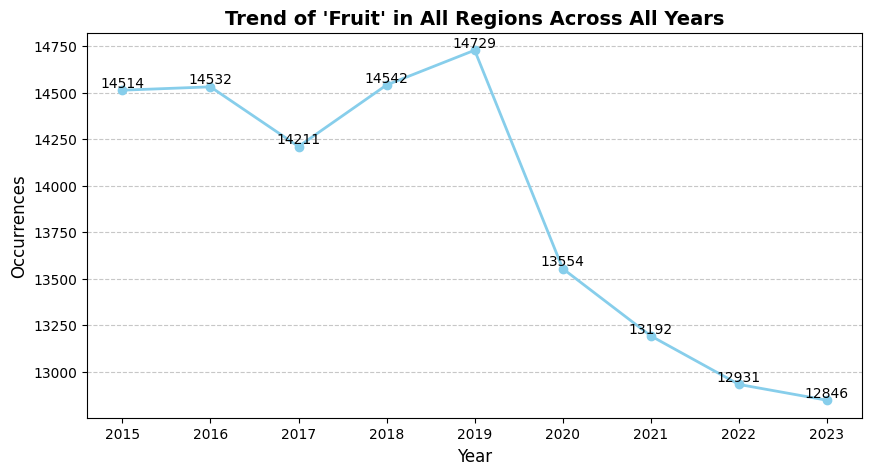

In [21]:
# Example Usage: Plot trend for 'Fruit' across all years
plot_flavor_trend(df, flavor="Fruit")

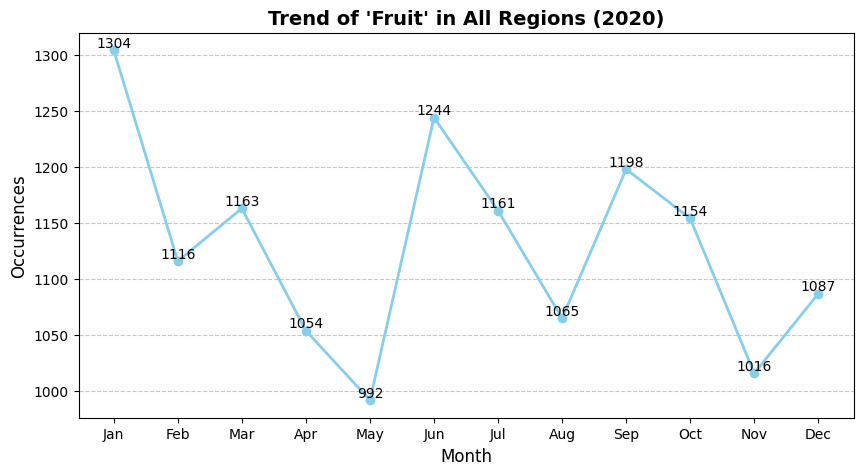

In [22]:
# Example Usage: Plot trend for 'Fruit' in a specific year (2020)
plot_flavor_trend(df, flavor="Fruit", year=2020)

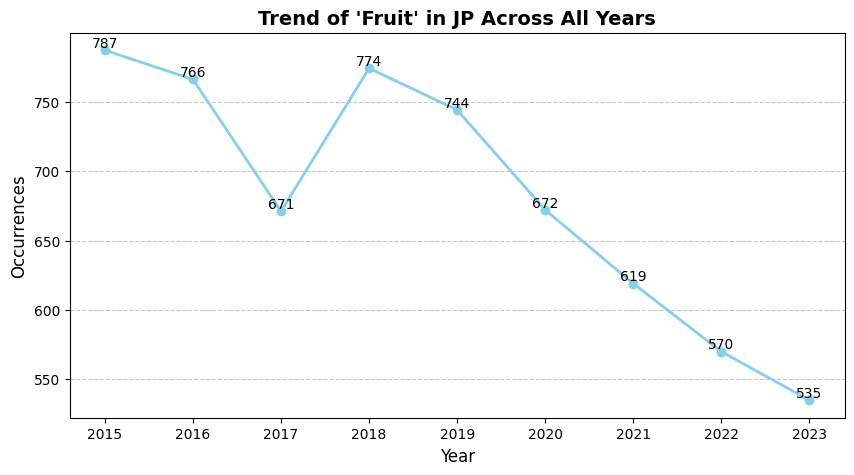

In [23]:
# Plot trend for 'Fruit' across all years in a specific country
plot_flavor_trend(df, flavor="Fruit", country="JP")

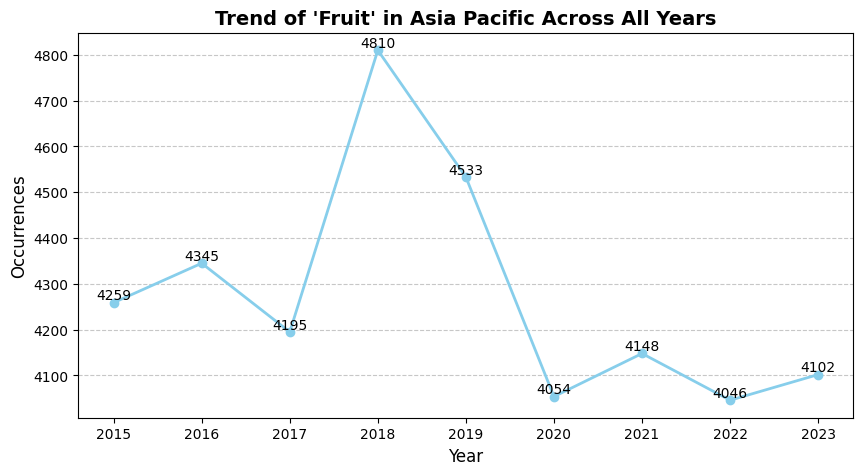

In [24]:
# Plot trend for 'Fruit' across all years in a region
plot_flavor_trend(df, flavor="Fruit", region="Asia Pacific")

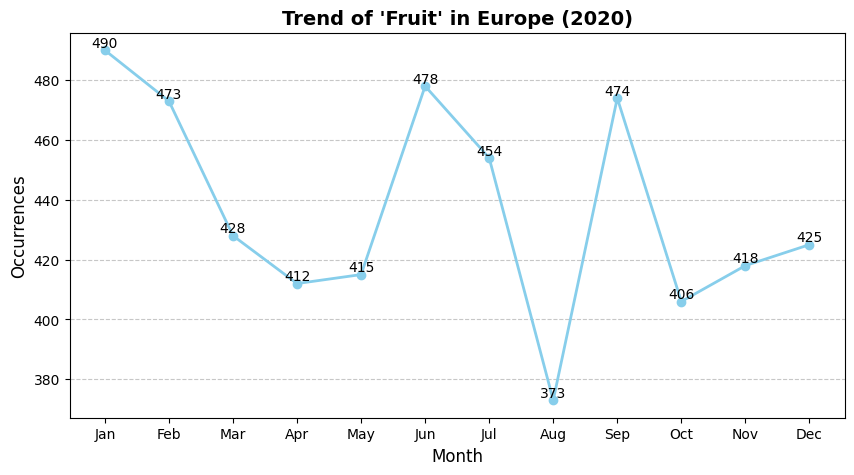

In [25]:
# Plot trend for 'Fruit' in a specific year (2020) in a specific region
plot_flavor_trend(df, flavor="Fruit", year=2020, region="Europe")